# **Exploratory Data Analysis**

Import Packages

In [57]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt

from torchinfo import summary

import xgboost as xgb
from xgboost import XGBRegressor


import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#--- Starting Here ---#

In [58]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [67]:
NVDA = 'NVDA'
SEMICONDUCTORS = ["TSM", "AVGO", "AMD", "ASML", "MRVL", "ON"]

#--- Preface: Min Max Scaler is Incorrect as we cannot find a reason to justify that the maximum in any of the features has been achieved ---#
#--- Preface Continued: The RSI values range from 0 to 100, so positive values in a fixed range for regression ---#
# Setup semiconductor data using Nvidia as starting place
semiConductor_data = yf.download(NVDA, start='2010-01-01', end='2024-01-01')
semiConductor_data.columns = [col[0] for col in semiConductor_data.columns]
semiConductor_data['RSI'] = calculate_rsi(semiConductor_data['Close'], window=14)
semiConductor_data.reset_index(inplace=True) # Removes date as index
semiConductor_data['Ticker'] = NVDA
semiConductor_data = semiConductor_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI']]
                                                            
#print(f"Total Data Length: {len(semiConductor_data)}")

for stock in SEMICONDUCTORS:

    stock_data = yf.download(stock, start="2010-01-01", end="2024-01-01")                                                                                          
    stock_data['Ticker'] = stock
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)
    stock_data.reset_index(inplace=True)
    stock_data.columns = [col[0] for col in stock_data.columns]

    # Add new stock data with RSI
    semiConductor_data = pd.concat([semiConductor_data, stock_data], ignore_index=True)

semiConductor_data.drop(columns=['Date',], inplace=True)
semiConductor_data = semiConductor_data.dropna()
semiConductor_data.to_csv("semiconductorData.csv", index=False)

print([ i for i in semiConductor_data['Ticker'].unique()])

stock_symbols = SEMICONDUCTORS + [NVDA]
for stock in stock_symbols:
    print(f"{stock} rows: {len(semiConductor_data.loc[semiConductor_data['Ticker'] == stock])}")

semiConductor_data['Ticker'], conversion = pd.factorize(semiConductor_data['Ticker'])

#'RSI', 'Close', 'High', 'Low', 'Open', 'Volume'
print(semiConductor_data.columns)
print(semiConductor_data.dtypes)
print(f"Conversion: {conversion}")
semiConductor_data.head(5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['NVDA', 'TSM', 'AVGO', 'AMD', 'ASML', 'MRVL', 'ON']
TSM rows: 3509
AVGO rows: 3509
AMD rows: 3509
ASML rows: 3509
MRVL rows: 3509
ON rows: 3509
NVDA rows: 3509
Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI'], dtype='object')
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
Ticker      int64
RSI       float64
dtype: object
Conversion: Index(['NVDA', 'TSM', 'AVGO', 'AMD', 'ASML', 'MRVL', 'ON'], dtype='object')


,Close,High,Low,Open,Volume,Ticker,RSI
13,0.377380,0.393429,0.375088,0.386322,1067916000,0,24.688242
14,0.383800,0.391137,0.380820,0.383571,643676000,0,29.603843
15,0.371649,0.384488,0.371420,0.381966,714636000,0,21.978142
16,0.381737,0.383112,0.367293,0.371420,812504000,0,27.104722
17,0.368898,0.386093,0.363624,0.384717,687764000,0,26.086959


# **Processing**

- create different datasets for different companies
- History sequence length: 60 days in advance
- Output sequence length: 5 days in future

Creating LSTM Dataset

In [80]:
class LSTMdataset(Dataset):
    def __init__(self, data, sequence_length, output_length):
        self.data = data
        self.data_values = self.data.values
        self.targetIDX = data.columns.tolist().index('RSI')
        self.sequence_length = sequence_length
        self.output_length = output_length
        self.sample_length = sequence_length + output_length
        
        self.valid_indices = []
        for i in range(len(self.data) - self.sample_length + 1):
            if i + self.sample_length <= len(self.data):
                self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        if idx >= len(self.valid_indices):
            raise IndexError("Index out of bounds")
            
        dayIDX = self.valid_indices[idx]
        
        history = self.data_values[dayIDX:dayIDX + self.sequence_length]
        forecast = self.data_values[dayIDX + self.sequence_length:dayIDX + self.sample_length, self.targetIDX]
        
        if len(history) != self.sequence_length or len(forecast) != self.output_length:
            raise ValueError(f"Inconsistent sequence length at index {idx}")

        history_tensor = torch.tensor(history, dtype=torch.float32)
        forecast_tensor = torch.tensor(forecast, dtype=torch.float32)

        return history_tensor, forecast_tensor

In [81]:
stock_loaders = {}

stocks = semiConductor_data['Ticker'].unique()

#-- INFO --#
shuffle = True
batch_size = 32

for stock in stocks:
    stock_data = semiConductor_data.loc[semiConductor_data['Ticker'] == stock]
    stock_data = stock_data.drop(columns='Ticker')
    lstmdataset = LSTMdataset(data=stock_data, sequence_length=60, output_length=5)
    stock_loader = DataLoader(lstmdataset, batch_size, shuffle)

    stock_loaders[stock] = stock_loader

print(f"Dataloaders: {len(stock_loaders)}")
print(f"Dictionary: {stock_loaders}")

Dataloaders: 7
Dictionary: {np.int64(0): <torch.utils.data.dataloader.DataLoader object at 0x000001E8997566C0>, np.int64(1): <torch.utils.data.dataloader.DataLoader object at 0x000001E8996D6000>, np.int64(2): <torch.utils.data.dataloader.DataLoader object at 0x000001E89987EE40>, np.int64(3): <torch.utils.data.dataloader.DataLoader object at 0x000001E90794E8D0>, np.int64(4): <torch.utils.data.dataloader.DataLoader object at 0x000001E90794EDB0>, np.int64(5): <torch.utils.data.dataloader.DataLoader object at 0x000001E9060808F0>, np.int64(6): <torch.utils.data.dataloader.DataLoader object at 0x000001E906081DC0>}


Split into Train and Test loaders

In [82]:
test_ratio = 0.2
stock_train_loaders = {}
stock_test_loaders = {}

for stock, loader in stock_loaders.items():
    dataset = loader.dataset

    dataset_size = len(dataset)
    test_size = int(test_ratio * dataset_size)
    train_size = dataset_size - test_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=loader.batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=loader.batch_size, shuffle=False, drop_last=True)
    
    stock_train_loaders[stock] = train_loader
    stock_test_loaders[stock] = test_loader

print(f"Training Loaders: {len(stock_train_loaders)}")
print(f"Testing Loaders: {len(stock_test_loaders)}")

Training Loaders: 7
Testing Loaders: 7


Create Model

In [98]:

class LSTMRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMRegression, self).__init__()

        # ----- LAYERS ----- #
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 128, batch_first=True)

        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(64, output_size)

        self.batch_norm1 = nn.BatchNorm1d(128)  # Apply to final LSTM output
        self.batch_norm2 = nn.BatchNorm1d(64)  # Apply after first dense layer

        # ----- ACTIVATION FUNCTIONS ----- #
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # ----- LSTM LAYERS ----- #
        #print(f"Input shape: {x.shape}")
        out, _ = self.lstm1(x)
        #print(f"Layer 1 shape: {out.shape}")
        out, _ = self.lstm2(out)
        #print(f"Layer 2 shape: {out}")
        out = out[:, -1, :]  # Shape: [batch_size, 128]
        #print(f"Reshape 1 shape: {out}")
        # Apply Batch Normalization
        out = self.batch_norm1(out)
        
        # ----- DENSE LAYERS ----- #
        out = self.dense1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.batch_norm2(out)
        out = self.dense2(out)

        return out


Model and specifics instantiations

In [99]:
model = LSTMRegression(input_size=6, output_size=5).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

LSTMRegression(
  (lstm1): LSTM(6, 128, batch_first=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (dense1): Linear(in_features=128, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=5, bias=True)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


Training Portion

Training on stock: 0
Company: 0, Epoch: 0, Average Epoch Loss: 290.0810
Company: 0, Epoch: 1, Average Epoch Loss: 289.2029
Company: 0, Epoch: 2, Average Epoch Loss: 289.0232
Company: 0, Epoch: 3, Average Epoch Loss: 289.5345
Company: 0, Epoch: 4, Average Epoch Loss: 289.4567
Company: 0, Epoch: 5, Average Epoch Loss: 288.9998
Company: 0, Epoch: 6, Average Epoch Loss: 289.2518
Company: 0, Epoch: 7, Average Epoch Loss: 289.5028
Company: 0, Epoch: 8, Average Epoch Loss: 289.2559
Company: 0, Epoch: 9, Average Epoch Loss: 288.6705
Company: 0, Epoch: 10, Average Epoch Loss: 289.1933
Company: 0, Epoch: 11, Average Epoch Loss: 289.1592
Company: 0, Epoch: 12, Average Epoch Loss: 288.9071
Company: 0, Epoch: 13, Average Epoch Loss: 289.3636
Company: 0, Epoch: 14, Average Epoch Loss: 288.8189
Company: 0, Epoch: 15, Average Epoch Loss: 288.9820
Company: 0, Epoch: 16, Average Epoch Loss: 288.9804
Company: 0, Epoch: 17, Average Epoch Loss: 289.4151
Company: 0, Epoch: 18, Average Epoch Loss: 289.2773
C

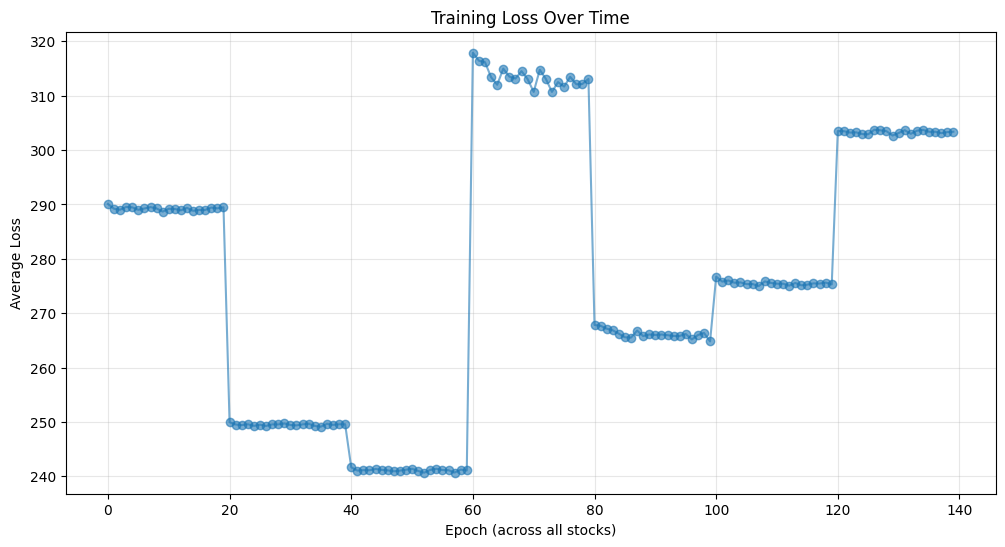

In [101]:
epochs = 20

model.train()
losses = []

for sym, train_loader in stock_train_loaders.items():
    print(f"Training on stock: {sym}")
    stock_losses = [] 
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            
            epoch_loss += loss.item()
            batch_count += 1
            
            loss.backward()
            optimizer.step()
        
        avg_epoch_loss = epoch_loss / batch_count
        stock_losses.append(avg_epoch_loss)
        print(f"Company: {sym}, Epoch: {epoch}, Average Epoch Loss: {avg_epoch_loss:.4f}")
    
    losses.extend(stock_losses)

plt.figure(figsize=(12, 6))
xs = np.arange(len(losses))
plt.plot(xs, losses, marker='o', linestyle='-', alpha=0.6)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch (across all stocks)')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)
plt.show()


Symbol: 0
Average Loss: 543581.4613
Symbol: 1
Average Loss: 544049.1458
Symbol: 2
Average Loss: 542595.1012
Symbol: 3
Average Loss: 4868939.8542
Symbol: 4
Average Loss: 544402.7708
Symbol: 5
Average Loss: 548279.0595
Symbol: 6
Average Loss: 546705.0357


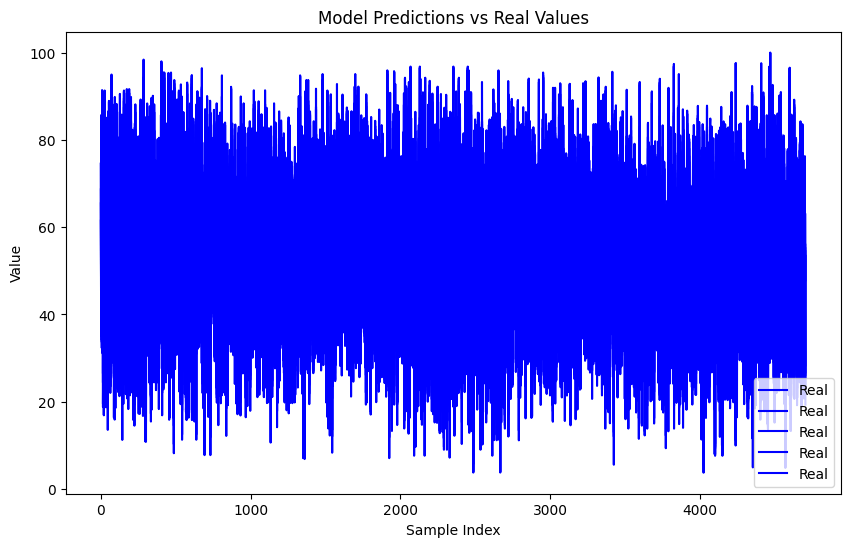

In [105]:
model.eval()
predictions = []
real = []

for sym, test_loader in stock_test_loaders.items():
    total_loss = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get model outputs (predictions)
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Store predictions and real values
            predictions.append(outputs.cpu().numpy())  # Moving to CPU for easier handling
            real.append(labels.cpu().numpy())  # Moving to CPU for easier handling
            
            total_samples += labels.size(0)

    avg_loss = total_loss / len(test_loader)

    print(f"Symbol: {sym}")
    print(f"Average Loss: {avg_loss:.4f}")

# Convert predictions and real lists to arrays for easier plotting
predictions = np.concatenate(predictions, axis=0)
real = np.concatenate(real, axis=0)

# Plot predictions vs real values
plt.figure(figsize=(10, 6))
plt.plot(real, label='Real', color='blue')
#plt.plot(predictions, label='Predicted', color='red', linestyle='dashed')
plt.legend()
plt.title("Model Predictions vs Real Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.show()